In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


CONTENT-BASED RECOMENDATION SYSTEM USING BOW AND TF_IDF MODELS

In [1]:
import warnings
import requests
from Utils import *
import pandas as pd
from collections import Counter 
from BagOfWordsModel import BagOfWordsModel
from TFIDFModel import TFIDFModel

In [2]:
def Get_And_Visualize_Data():
    data_set = pd.read_json('2pyij-qh9lc.json')
    print(" No. of Products (or data points) : ",data_set.shape[0],"\n No. of features: ",data_set.shape[1])
    print(data_set.columns) # total features 
    # Features we are gonna use :
    # brand,color,product_type_name,medium image url,title,formatted_price
    data_set = data_set[['nama_villa','jumlah_bedroom','villa_deskripsi','lokasi','image_villa-src','location_deskripsi','bedrooms_deskripsi']]
    # ASIN - Amazon consumer API--as an associate--asin(Amazon Standard Identification No.) - ID / primary key
    return data_set

In [3]:
data_set=Get_And_Visualize_Data()

 No. of Products (or data points) :  827 
 No. of features:  14
Index(['web-scraper-order', 'web-scraper-start-url', 'villa-link',
       'villa-link-href', 'nama_villa', 'jumlah_bedroom', 'villa_deskripsi',
       'bedrooms_deskripsi', 'outdoor_deskripsi', 'indoor_deskripsi',
       'more_deskripsi', 'location_deskripsi', 'lokasi', 'image_villa-src'],
      dtype='object')


In [4]:
def ExploratoryDataAnalysis(data_set):
    data_set.head()
    for feature in data_set.columns:
        print("\n\n\nSTATISTICS FOR FEATURE : ",feature.upper())
        print("\nDescription for Feature : \n")
        print(data_set[feature].describe())
        print("\nCount/Frequency for Feature : \n")
        data_set['nama_villa'].unique()
        print(Counter(list(data_set[feature])).most_common(10))

In [5]:
ExploratoryDataAnalysis(data_set)





STATISTICS FOR FEATURE :  NAMA_VILLA

Description for Feature : 

count                  827
unique                 823
top       Villa Yudhistira
freq                     2
Name: nama_villa, dtype: object

Count/Frequency for Feature : 

[('Villa Cantik', 2), ('Villa Matahari', 2), ('Villa Jasmine', 2), ('Villa Yudhistira', 2), ('Sungai Jungle Villa I', 1), ('Morabito Art Cliff', 1), ('Villa Vinila Penthouse', 1), ('Villa Sally', 1), ('Villa Ibiza', 1), ('Villa Jeruk 1', 1)]



STATISTICS FOR FEATURE :  JUMLAH_BEDROOM

Description for Feature : 

count            827
unique            15
top       3 bedrooms
freq             211
Name: jumlah_bedroom, dtype: object

Count/Frequency for Feature : 

[('3 bedrooms', 211), ('4 bedrooms', 188), ('5 bedrooms', 122), ('2 bedrooms', 104), ('1 bedroom', 73), ('6 bedrooms', 53), ('7 bedrooms', 29), ('8 bedrooms', 16), ('9 bedrooms', 11), ('10 bedrooms', 7)]



STATISTICS FOR FEATURE :  VILLA_DESKRIPSI

Description for Feature : 

count      8

In [13]:
import itertools
def Data_Preprocessing(data_set):
    # descending order of  of Null values in prices>color>brand
    data_set=RemoveNullValues(data_set)
    # Recommendtaion based on different size or color not a good recommendation
    data_set=RemoveDuplicateItemsAfterSorting(data_set)
    print(data_set.shape[0])
    data_set=RemoveDuplicateItemsNonAdjacent(data_set)
    return data_set

 
def RemoveNullValues(data_set):
    hav_null=['nama_villa','jumlah_bedroom']
    for features in hav_null:
        data_set=data_set.loc[-data_set[features].isnull()]
        print("\n\nNo. of data points after eliminating {}=NULL :\n".format(features),data_set.shape[0])
    return data_set

#Near Duplicate items remain
#remove data differing only at end(that is size difference or colour difference are not good recommendations)
def RemoveDuplicateItemsAfterSorting(data_set):
    print("\nThe duplicated items are : ",sum(data_set.duplicated('nama_villa')),"\n\n")
    #sort on the basis of the title(alphabetical order)
    data_set.sort_values('nama_villa',inplace=True,ascending=False)
    #print(data_set['title'].head(20))
    
    row_wise_str_index=[]
    for row_index,row in data_set.iterrows():
        row_wise_str_index.append(row_index)
    new_data_list=[]
    i=0
    j=0
    len_data_points = data_set.shape[0]
    while i<len_data_points and j<len_data_points:
        temp_i=i
        #wordlist for ith string
        i_str = data_set['nama_villa'].loc[row_wise_str_index[i]].split()
        j=i+1
        while j<len_data_points:
            j_str = data_set['nama_villa'].loc[row_wise_str_index[j]].split()
            max_len=max(len(i_str),len(j_str))
            count=0 #no. of words matching in both strings
            #itertools.zip_longest(i_str,j_str) return correspoinding words in format [('a1','b1'),('a2','b2'),(None,'b3')]
            for words in itertools.zip_longest(i_str,j_str):
                if words[0] == words[1]:
                    count+=1
            if(max_len-count>2):
                #word difference>2 both different items -- hence include
                new_data_list.append(data_set['nama_villa'].loc[row_wise_str_index[j]])
                if(max_len-1==j):
                    #word difference>2 but in len_data_points and len_data_points-1
                    new_data_list.append(data_set['nama_villa'].loc[row_wise_str_index[j]])
                i=j
                break
            else:
                j+=1
        if temp_i == i:
            break   
    data_set=data_set.loc[data_set['nama_villa'].isin(new_data_list)]
    return data_set

def RemoveDuplicateItemsNonAdjacent(data_set): # Time complexity = O(n^2) 
    row_wise_str_index=[]
    for row_index,row in data_set.iterrows():
        row_wise_str_index.append(row_index)
    new_data_list=[]
    while(len(row_wise_str_index)!=0):
        #remove the last element in the row_wise_str_index and return the index of the last element
        i = row_wise_str_index.pop()
        new_data_list.append(data_set['nama_villa'].loc[i])
        i_str=data_set['nama_villa'].loc[i].split()
        for j in row_wise_str_index:
            j_str = data_set['nama_villa'].loc[j].split()
            max_len = max(len(i_str),len(j_str))
            count = 0 #count of mathing words in the two strings
            for words in itertools.zip_longest(i_str,j_str):
                if words[0] == words[1]:
                    count+=1
            # word difference > 3 the words are considered different 
            if (max_len-count) < 3:
                row_wise_str_index.remove(j)
    data_set=data_set.loc[data_set['nama_villa'].isin(new_data_list)]
    return data_set


data_set=Data_Preprocessing(data_set)
#data_set=pd.read_pickle('Pickles/Preprocessed_Data_version2')
data_set





No. of data points after eliminating nama_villa=NULL :
 827


No. of data points after eliminating jumlah_bedroom=NULL :
 827

The duplicated items are :  4 


119


,nama_villa,jumlah_bedroom,villa_deskripsi,lokasi,image_villa-src,location_deskripsi,bedrooms_deskripsi
297,Villa Vinila Duplex 3 BR,3 bedrooms,Villa Vinila is a luxury resort located just 5...,Nusa Dua,https://cdn.villa-bali.com/cache/1024/villas/v...,The villa is located in the resort area of Nus...,The villa has 3 bedrooms and each of them has ...
469,Villa Umah Di Sawah,5 bedrooms,Villa Umah Di Sawah is a vacation compound tha...,Canggu,https://cdn.villa-bali.com/cache/1024/villas/v...,Villa Umah Di Sawa is situated in Canggu. Abo...,The villa has five air-conditioned bedrooms. ...
595,Villa Uma Wana Prasta,7 bedrooms,Villa Uma Wana Prasta is a gorgeous 7-bedroom ...,Canggu,https://cdn.villa-bali.com/cache/1024/villas/v...,Villa Uma Wana Prasta is located in a peaceful...,"The spacious, opulent master suite is tucked i..."
55,Villa Sound of the Sea,6 bedrooms,Villa Sound of the Sea is one of the five luxu...,Canggu,https://cdn.villa-bali.com/cache/1024/villas/v...,Villa Sound of the Sea is located at Pererenan...,The master suite has the best ocean view from ...
495,Villa Sol y Mar,4 bedrooms,With a stunning vista that spans across Uluwat...,Uluwatu,https://cdn.villa-bali.com/cache/1024/villas/v...,The villa offers a small path outdoors that le...,Villa Sol y Mar has been blessed with four stu...
419,Villa Seriska Satu Seminyak,3 bedrooms,This luxurious 3 bedroom villa is found at the...,Seminyak,https://cdn.villa-bali.com/cache/1024/villas/v...,"The villa is located just off of Jalan Kunti, ...",The master suite is adjoined to the living pav...
390,Villa Selong Selo 5,5 bedrooms,Villa Selong Selo 5 is one of the luxurious vi...,Lombok,https://cdn.villa-bali.com/cache/1024/villas/v...,Villa Selong Selo 5 is an ideal destination fo...,The five-bedroom villa is the most perfect sta...
53,Villa Putih Nusa Lembongan,4 bedrooms,This contemporary luxury villa makes an amazin...,Nusa Lembongan,https://cdn.villa-bali.com/cache/1024/villas/v...,Villa Putih is located in a quiet yet upscale ...,No one has to miss out on the ocean view when ...
640,Villa Luwak 2 Valley,2 bedrooms,Nestled amidst the luscious landscape of Ubud ...,Ubud & surroundings,https://cdn.villa-bali.com/cache/1024/villas/v...,Ubud is known as the cultural hub of Bali with...,"To ensure your privacy, the two bedrooms at Vi..."
162,Villa Kubu Dewi Sri,5 bedrooms,"Nestled in the peaceful Berawa area of Canggu,...",Canggu,https://cdn.villa-bali.com/cache/1024/villas/v...,Villa Kubu Dewi Sri is nestled in the rice pad...,Full length glass sliding doors open up to the...


In [ ]:
#data_set=TextPreprocessing(data_set)
data_set=pd.read_pickle('Pickles/Preprocessed_Data_version3')
data_set

Enter the Apparal ID : 
1


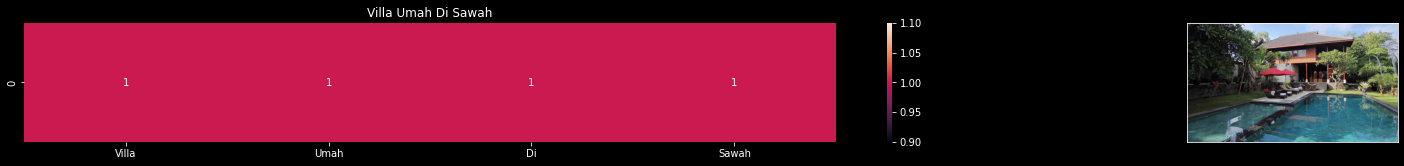

TITLE : Villa Umah Di Sawah
BRAND : Canggu
Similarity Index(Euclidian Similarity) : 0.0
______________________________________________________________________


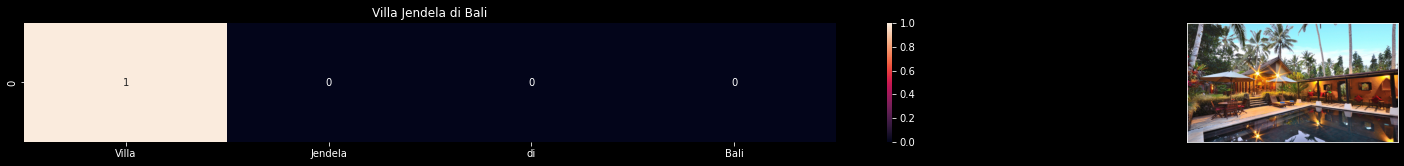

TITLE : Villa Jendela di Bali
BRAND : Ubud & surroundings
Similarity Index(Euclidian Similarity) : 2.0
______________________________________________________________________


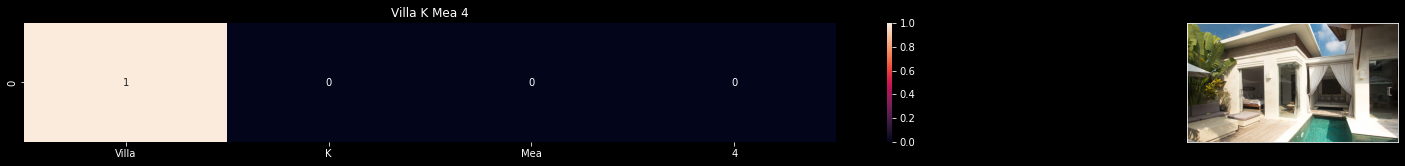

TITLE : Villa K Mea 4
BRAND : Seminyak
Similarity Index(Euclidian Similarity) : 2.0
______________________________________________________________________


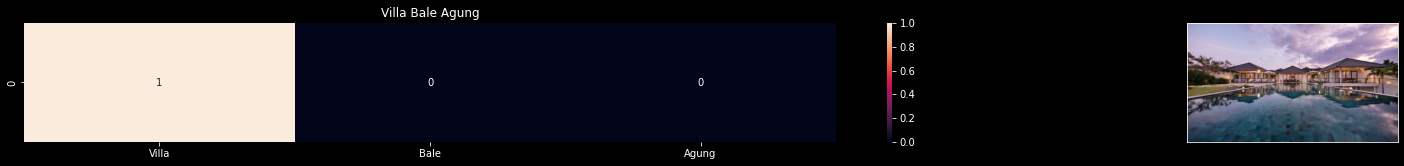

TITLE : Villa Bale Agung
BRAND : Uluwatu
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


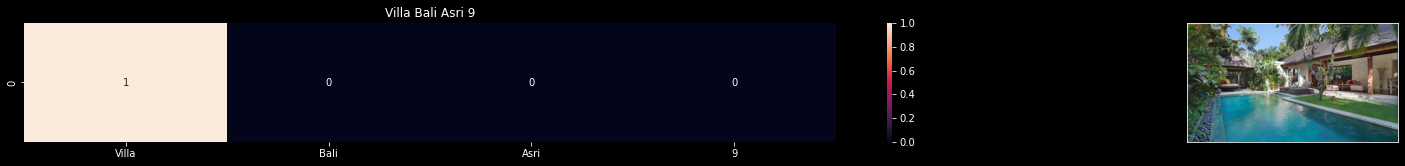

TITLE : Villa Bali Asri 9
BRAND : Seminyak
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


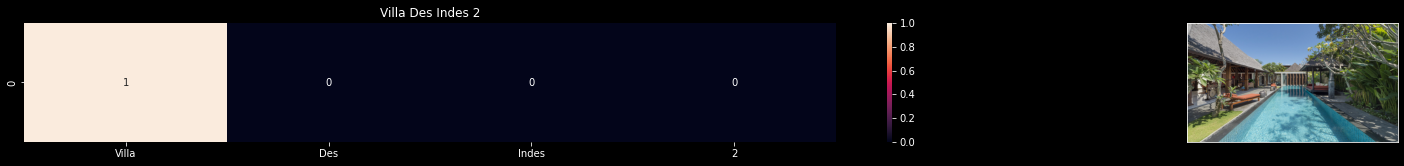

TITLE : Villa Des Indes 2
BRAND : Seminyak
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


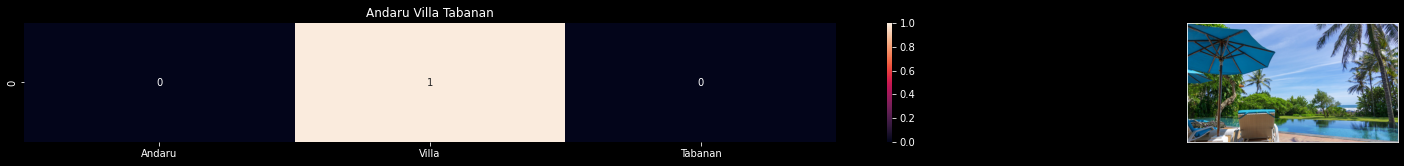

TITLE : Andaru Villa Tabanan
BRAND : Tabanan
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


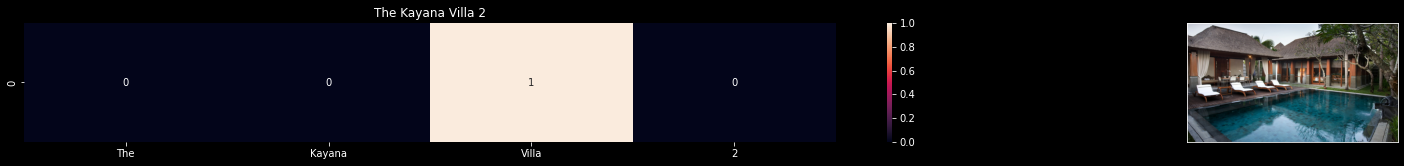

TITLE : The Kayana Villa 2
BRAND : Seminyak
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


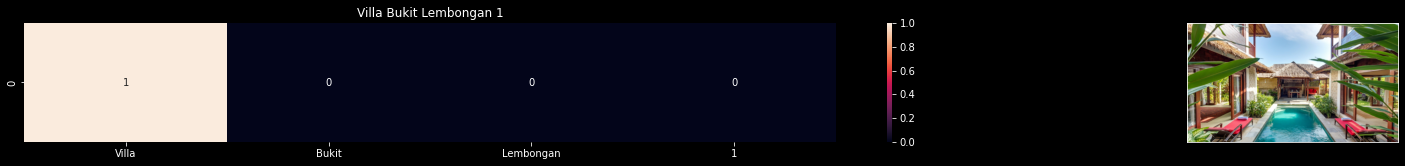

TITLE : Villa Bukit Lembongan 1
BRAND : Nusa Lembongan
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


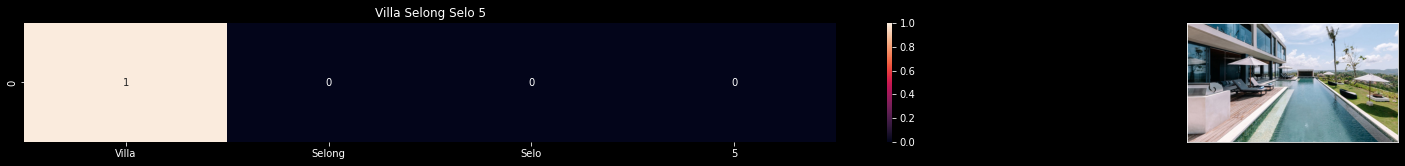

TITLE : Villa Selong Selo 5
BRAND : Lombok
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


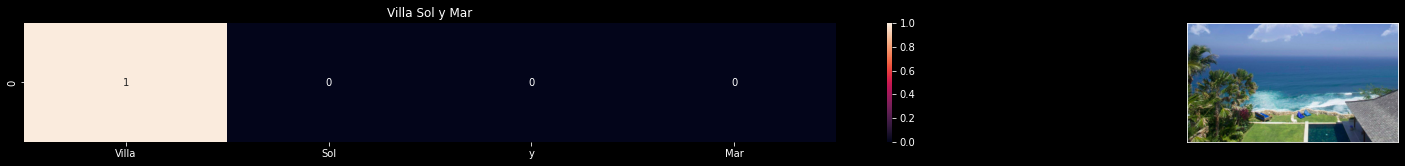

TITLE : Villa Sol y Mar
BRAND : Uluwatu
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


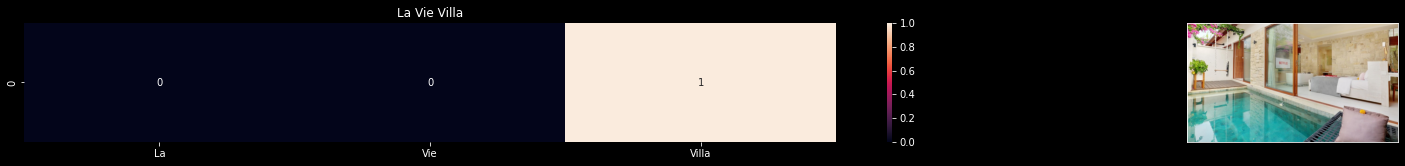

TITLE : La Vie Villa
BRAND : Legian
Similarity Index(Euclidian Similarity) : 2.23606797749979
______________________________________________________________________


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f05adf41350>

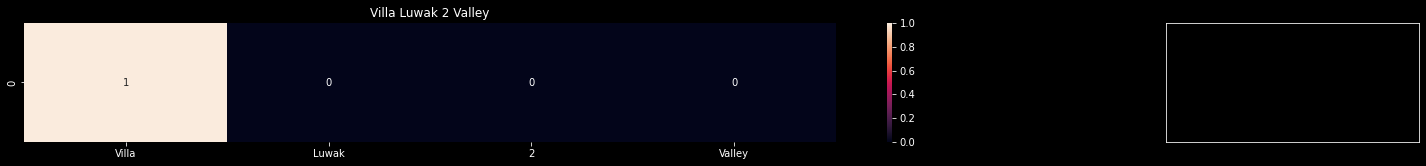

In [18]:
import re
from io import BytesIO
from Utils import *
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from PIL import Image
import numpy as np

def BagOfWordsModel(data_set):
    #we use the 'title' feature for recommendation
    VectorizedTitles=Vectorize(data_set)
    apparel_id=int(input("Enter the Apparal ID : \n"))
    num_recc=20
    pairwise_dist = pairwise_distances(VectorizedTitles,VectorizedTitles[apparel_id])
    recc_indices = np.argsort(pairwise_dist.flatten())[0:num_recc]
    recc_pdists = np.sort(pairwise_dist.flatten())[0:num_recc]
    df_recc_indices = list(data_set.index[recc_indices])
    for i in range(0,len(recc_indices)):
        GetRecomendations(recc_indices[i],data_set['nama_villa'].loc[df_recc_indices[0]],data_set['nama_villa'].loc[df_recc_indices[i]],data_set['image_villa-src'].loc[df_recc_indices[i]],'bag_of_words')
        print('TITLE :',data_set['nama_villa'].loc[df_recc_indices[i]])
        print('BRAND :',data_set['lokasi'].loc[df_recc_indices[i]])
        print('Similarity Index(Euclidian Similarity) :',recc_pdists[i])
        print("_"*70)
        
def Vectorize(data_set):
    Count_Vectorizer=CountVectorizer()
    VectorizedTitles=Count_Vectorizer.fit_transform(data_set['nama_villa'])
    return VectorizedTitles

BagOfWordsModel(data_set)

In [ ]:
TFIDFModel(data_set)